PubCrawl Simulation Developer Notebook

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','grid'])
import Pub

In [11]:
### init the Pubs
# load the Pub CSV
pubsList = np.genfromtxt('Pubs.csv', delimiter=',', dtype=str, skip_header=1)
# init the Pubs 
Pubs = []
for i in range(pubsList.shape[0]):
    pubID = pubsList[i][0]
    openingTime = pubsList[i][1]
    closingTime = pubsList[i][2]
    popularity = pubsList[i][3]
    posX = pubsList[i][4]
    posY = pubsList[i][5]
    # create the Pub
    pub = Pub.Pub(pubID, openingTime, closingTime, popularity, posX, posY)
    Pubs.append(pub)

In [12]:
def showPubMap(Pubs):
    # loop over the Pubs, extract the x and y coordinates and plot them
    x = []
    y = []
    for pub in Pubs:
        x.append(pub.posX)
        y.append(pub.posY)
    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Pub Map')
    plt.show()
    

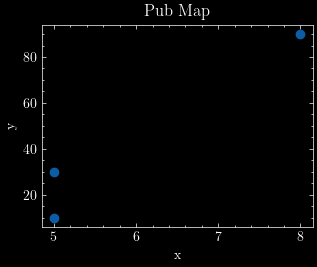

In [13]:
showPubMap(Pubs)

In [14]:
currentTime = 10

# show waiting times for all pubs
for p in Pubs:
    print('Pub ID: ', p.pubID, ' Waiting Time: ', p.getWaitingTime(currentTime))

Pub ID:  1  Waiting Time:  100
Pub ID:  2  Waiting Time:  3.0
Pub ID:  3  Waiting Time:  93


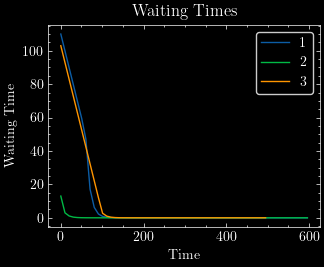

In [15]:
currT = np.linspace(0, 1000, 100)

# evaluate the waiting time for all pubs at different times
for p in Pubs:
    waitingTimes = []
    for t in currT:
        waitingTimes.append(p.getWaitingTime(t))
    plt.plot(currT, waitingTimes, label=p.pubID)
    plt.xlabel('Time')
    plt.ylabel('Waiting Time')
    plt.title('Waiting Times')
    plt.legend()

# plot wainting times for all pubs in a subplot

